In [1]:
import logging

import probtorch
import torch

import combinators
import importance
import mcmc
import ssm
import trace_tries
import utils

In [2]:
logging.basicConfig(format='%(asctime)s %(message)s', datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO)

In [3]:
mu = torch.zeros(1)
sigma = torch.ones(1) / 2
delta = torch.ones(1)
zs = torch.ones(50+1) * -1
zs[0] = 0

In [4]:
ssm_step = combinators.PrimitiveCall(ssm.ssm_step)
ssm_initializer = combinators.ReturnModel(zs[0], mu, sigma, delta)
ssm_sequence = combinators.Reduce(ssm_step, generator=lambda: range(zs.shape[0]-1), initializer=ssm_initializer)

In [5]:
_, generative = ssm_sequence()

In [6]:
data = {k.rpartition('/')[-1]: rv.value for (k, rv) in generative.filter(lambda k, rv: 'X_' in k)}

In [7]:
particle_shape = (100,)

In [8]:
ssm_params = {
    'mu': {
        'loc': torch.tensor(0.),
        'scale': torch.tensor(0.25),
    },
    'sigma': {
        'loc': torch.tensor(1.),
        'scale': torch.tensor(0.25),
    },
    'delta': {
        'loc': torch.tensor(0.),
        'scale': torch.tensor(0.25),
    }
}

In [9]:
init_ssm_generative = combinators.HyperPopulation(ssm.init_ssm, particle_shape, hyper=ssm_params)
ssm_step_generative = combinators.PrimitiveCall(ssm.ssm_step)
ssm_generative = combinators.Reduce(ssm_step_generative, generator=lambda: range(50), initializer=init_ssm_generative)

In [10]:
init_ssm_proposal = combinators.HyperPopulation(ssm.init_ssm, particle_shape, trainable=ssm_params)
ssm_step_proposal = combinators.PrimitiveCall(ssm.ssm_step)
ssm_proposal = importance.smc(ssm_step_proposal, particle_shape, lambda: range(50), initializer=init_ssm_proposal)

In [11]:
ssm_score = combinators.score_under_proposal(ssm_proposal, ssm_generative)

In [12]:
inference, init_ssm_params, elbos = importance.variational_importance(
    ssm_score, 1000, data, use_cuda=False,
    lr=1e-3, patience=100
)

11/24/2018 12:25:37 ELBO=-6.21035347e+01 at epoch 1
11/24/2018 12:25:38 ELBO=-5.98152199e+01 at epoch 2
11/24/2018 12:25:38 ELBO=-6.18897552e+01 at epoch 3
11/24/2018 12:25:38 ELBO=-6.27099228e+01 at epoch 4
11/24/2018 12:25:38 ELBO=-5.70818634e+01 at epoch 5
11/24/2018 12:25:38 ELBO=-6.18143654e+01 at epoch 6
11/24/2018 12:25:38 ELBO=-5.60359116e+01 at epoch 7
11/24/2018 12:25:38 ELBO=-6.04837914e+01 at epoch 8
11/24/2018 12:25:38 ELBO=-5.44706268e+01 at epoch 9
11/24/2018 12:25:38 ELBO=-6.06593628e+01 at epoch 10
11/24/2018 12:25:38 ELBO=-6.54242172e+01 at epoch 11
11/24/2018 12:25:38 ELBO=-5.72632141e+01 at epoch 12
11/24/2018 12:25:39 ELBO=-6.46841660e+01 at epoch 13
11/24/2018 12:25:39 ELBO=-6.40037155e+01 at epoch 14
11/24/2018 12:25:39 ELBO=-6.41516342e+01 at epoch 15
11/24/2018 12:25:39 ELBO=-6.63273468e+01 at epoch 16
11/24/2018 12:25:39 ELBO=-6.46914978e+01 at epoch 17
11/24/2018 12:25:39 ELBO=-6.69906921e+01 at epoch 18
11/24/2018 12:25:39 ELBO=-6.17738914e+01 at epoch 19
11

Epoch   123: reducing learning rate of group 0 to 5.0000e-04.


11/24/2018 12:25:51 ELBO=-6.66855469e+01 at epoch 126
11/24/2018 12:25:52 ELBO=-5.86248741e+01 at epoch 127
11/24/2018 12:25:52 ELBO=-6.70724258e+01 at epoch 128
11/24/2018 12:25:52 ELBO=-6.12968941e+01 at epoch 129
11/24/2018 12:25:52 ELBO=-6.36456146e+01 at epoch 130
11/24/2018 12:25:52 ELBO=-6.23656769e+01 at epoch 131
11/24/2018 12:25:52 ELBO=-6.32976952e+01 at epoch 132
11/24/2018 12:25:52 ELBO=-6.25914345e+01 at epoch 133
11/24/2018 12:25:52 ELBO=-6.37392845e+01 at epoch 134
11/24/2018 12:25:53 ELBO=-5.31760941e+01 at epoch 135
11/24/2018 12:25:53 ELBO=-5.65259514e+01 at epoch 136
11/24/2018 12:25:53 ELBO=-6.44335403e+01 at epoch 137
11/24/2018 12:25:53 ELBO=-6.21975670e+01 at epoch 138
11/24/2018 12:25:53 ELBO=-6.36758232e+01 at epoch 139
11/24/2018 12:25:53 ELBO=-6.29030151e+01 at epoch 140
11/24/2018 12:25:53 ELBO=-5.53530540e+01 at epoch 141
11/24/2018 12:25:53 ELBO=-6.31515198e+01 at epoch 142
11/24/2018 12:25:54 ELBO=-6.25094719e+01 at epoch 143
11/24/2018 12:25:54 ELBO=-6.

Epoch   282: reducing learning rate of group 0 to 2.5000e-04.


11/24/2018 12:26:11 ELBO=-5.55383110e+01 at epoch 285
11/24/2018 12:26:11 ELBO=-6.02481995e+01 at epoch 286
11/24/2018 12:26:11 ELBO=-6.23392220e+01 at epoch 287
11/24/2018 12:26:11 ELBO=-6.63589706e+01 at epoch 288
11/24/2018 12:26:12 ELBO=-6.52319717e+01 at epoch 289
11/24/2018 12:26:12 ELBO=-5.99741516e+01 at epoch 290
11/24/2018 12:26:12 ELBO=-6.30717888e+01 at epoch 291
11/24/2018 12:26:12 ELBO=-6.78708344e+01 at epoch 292
11/24/2018 12:26:12 ELBO=-5.99531059e+01 at epoch 293
11/24/2018 12:26:12 ELBO=-6.47197342e+01 at epoch 294
11/24/2018 12:26:12 ELBO=-6.44499741e+01 at epoch 295
11/24/2018 12:26:12 ELBO=-6.29407234e+01 at epoch 296
11/24/2018 12:26:13 ELBO=-6.13469048e+01 at epoch 297
11/24/2018 12:26:13 ELBO=-6.54647064e+01 at epoch 298
11/24/2018 12:26:13 ELBO=-6.47104034e+01 at epoch 299
11/24/2018 12:26:13 ELBO=-6.61133804e+01 at epoch 300
11/24/2018 12:26:13 ELBO=-6.33549118e+01 at epoch 301
11/24/2018 12:26:13 ELBO=-6.04149323e+01 at epoch 302
11/24/2018 12:26:13 ELBO=-6.

Epoch   383: reducing learning rate of group 0 to 1.2500e-04.


11/24/2018 12:26:25 ELBO=-6.47151947e+01 at epoch 386
11/24/2018 12:26:25 ELBO=-6.51390533e+01 at epoch 387
11/24/2018 12:26:25 ELBO=-6.88101196e+01 at epoch 388
11/24/2018 12:26:25 ELBO=-6.48823166e+01 at epoch 389
11/24/2018 12:26:26 ELBO=-6.74738693e+01 at epoch 390
11/24/2018 12:26:26 ELBO=-6.46113739e+01 at epoch 391
11/24/2018 12:26:26 ELBO=-6.67959442e+01 at epoch 392
11/24/2018 12:26:26 ELBO=-6.30205574e+01 at epoch 393
11/24/2018 12:26:26 ELBO=-5.98716316e+01 at epoch 394
11/24/2018 12:26:27 ELBO=-6.11381836e+01 at epoch 395
11/24/2018 12:26:27 ELBO=-6.36865082e+01 at epoch 396
11/24/2018 12:26:27 ELBO=-6.02220001e+01 at epoch 397
11/24/2018 12:26:27 ELBO=-5.96990166e+01 at epoch 398
11/24/2018 12:26:28 ELBO=-5.83551254e+01 at epoch 399
11/24/2018 12:26:28 ELBO=-6.55037994e+01 at epoch 400
11/24/2018 12:26:28 ELBO=-6.63353806e+01 at epoch 401
11/24/2018 12:26:28 ELBO=-6.12701683e+01 at epoch 402
11/24/2018 12:26:28 ELBO=-6.31772537e+01 at epoch 403
11/24/2018 12:26:28 ELBO=-6.

Epoch   484: reducing learning rate of group 0 to 6.2500e-05.


11/24/2018 12:26:45 ELBO=-5.74920578e+01 at epoch 487
11/24/2018 12:26:46 ELBO=-6.30770149e+01 at epoch 488
11/24/2018 12:26:46 ELBO=-6.66522751e+01 at epoch 489
11/24/2018 12:26:46 ELBO=-6.12765846e+01 at epoch 490
11/24/2018 12:26:46 ELBO=-6.69637146e+01 at epoch 491
11/24/2018 12:26:46 ELBO=-6.29976730e+01 at epoch 492
11/24/2018 12:26:47 ELBO=-6.83949051e+01 at epoch 493
11/24/2018 12:26:47 ELBO=-5.65232925e+01 at epoch 494
11/24/2018 12:26:47 ELBO=-6.62886658e+01 at epoch 495
11/24/2018 12:26:47 ELBO=-5.56451302e+01 at epoch 496
11/24/2018 12:26:47 ELBO=-6.38789520e+01 at epoch 497
11/24/2018 12:26:47 ELBO=-6.26707535e+01 at epoch 498
11/24/2018 12:26:48 ELBO=-6.45950089e+01 at epoch 499
11/24/2018 12:26:48 ELBO=-6.46781387e+01 at epoch 500
11/24/2018 12:26:48 ELBO=-6.30891953e+01 at epoch 501
11/24/2018 12:26:48 ELBO=-5.90032921e+01 at epoch 502
11/24/2018 12:26:48 ELBO=-6.56819534e+01 at epoch 503
11/24/2018 12:26:48 ELBO=-6.30600700e+01 at epoch 504
11/24/2018 12:26:49 ELBO=-6.

Epoch   585: reducing learning rate of group 0 to 3.1250e-05.


11/24/2018 12:27:00 ELBO=-6.33802490e+01 at epoch 588
11/24/2018 12:27:00 ELBO=-6.02026978e+01 at epoch 589
11/24/2018 12:27:00 ELBO=-6.34853706e+01 at epoch 590
11/24/2018 12:27:00 ELBO=-6.60257416e+01 at epoch 591
11/24/2018 12:27:01 ELBO=-5.87183533e+01 at epoch 592
11/24/2018 12:27:01 ELBO=-6.74174652e+01 at epoch 593
11/24/2018 12:27:01 ELBO=-6.32059250e+01 at epoch 594
11/24/2018 12:27:01 ELBO=-6.46658859e+01 at epoch 595
11/24/2018 12:27:01 ELBO=-6.11598320e+01 at epoch 596
11/24/2018 12:27:01 ELBO=-5.82361031e+01 at epoch 597
11/24/2018 12:27:02 ELBO=-6.41035843e+01 at epoch 598
11/24/2018 12:27:02 ELBO=-6.55205154e+01 at epoch 599
11/24/2018 12:27:02 ELBO=-6.45829544e+01 at epoch 600
11/24/2018 12:27:02 ELBO=-5.95139389e+01 at epoch 601
11/24/2018 12:27:02 ELBO=-6.49162292e+01 at epoch 602
11/24/2018 12:27:02 ELBO=-6.01882706e+01 at epoch 603
11/24/2018 12:27:03 ELBO=-6.53163605e+01 at epoch 604
11/24/2018 12:27:03 ELBO=-6.17212639e+01 at epoch 605
11/24/2018 12:27:03 ELBO=-6.

Epoch   686: reducing learning rate of group 0 to 1.5625e-05.


11/24/2018 12:27:20 ELBO=-6.43064728e+01 at epoch 689
11/24/2018 12:27:20 ELBO=-6.34364929e+01 at epoch 690
11/24/2018 12:27:20 ELBO=-6.77869415e+01 at epoch 691
11/24/2018 12:27:20 ELBO=-6.53513794e+01 at epoch 692
11/24/2018 12:27:20 ELBO=-6.19158936e+01 at epoch 693
11/24/2018 12:27:21 ELBO=-6.37264023e+01 at epoch 694
11/24/2018 12:27:21 ELBO=-6.25504837e+01 at epoch 695
11/24/2018 12:27:21 ELBO=-6.56978531e+01 at epoch 696
11/24/2018 12:27:21 ELBO=-6.30914268e+01 at epoch 697
11/24/2018 12:27:21 ELBO=-6.55220718e+01 at epoch 698
11/24/2018 12:27:21 ELBO=-6.11983185e+01 at epoch 699
11/24/2018 12:27:21 ELBO=-5.77058792e+01 at epoch 700
11/24/2018 12:27:22 ELBO=-6.88137665e+01 at epoch 701
11/24/2018 12:27:22 ELBO=-6.35375481e+01 at epoch 702
11/24/2018 12:27:22 ELBO=-6.56884766e+01 at epoch 703
11/24/2018 12:27:22 ELBO=-6.96363068e+01 at epoch 704
11/24/2018 12:27:22 ELBO=-6.43474808e+01 at epoch 705
11/24/2018 12:27:22 ELBO=-6.33504906e+01 at epoch 706
11/24/2018 12:27:22 ELBO=-6.

Epoch   787: reducing learning rate of group 0 to 7.8125e-06.


11/24/2018 12:27:34 ELBO=-6.62211685e+01 at epoch 790
11/24/2018 12:27:34 ELBO=-7.01501007e+01 at epoch 791
11/24/2018 12:27:34 ELBO=-5.57687683e+01 at epoch 792
11/24/2018 12:27:34 ELBO=-6.43516541e+01 at epoch 793
11/24/2018 12:27:34 ELBO=-6.52531738e+01 at epoch 794
11/24/2018 12:27:34 ELBO=-6.09342384e+01 at epoch 795
11/24/2018 12:27:34 ELBO=-6.54469528e+01 at epoch 796
11/24/2018 12:27:34 ELBO=-6.44869080e+01 at epoch 797
11/24/2018 12:27:35 ELBO=-6.69154510e+01 at epoch 798
11/24/2018 12:27:35 ELBO=-6.04257469e+01 at epoch 799
11/24/2018 12:27:35 ELBO=-6.50204391e+01 at epoch 800
11/24/2018 12:27:35 ELBO=-6.30810089e+01 at epoch 801
11/24/2018 12:27:35 ELBO=-6.15532074e+01 at epoch 802
11/24/2018 12:27:35 ELBO=-6.90628433e+01 at epoch 803
11/24/2018 12:27:35 ELBO=-6.17343178e+01 at epoch 804
11/24/2018 12:27:36 ELBO=-6.35687981e+01 at epoch 805
11/24/2018 12:27:36 ELBO=-6.60972061e+01 at epoch 806
11/24/2018 12:27:36 ELBO=-6.14116325e+01 at epoch 807
11/24/2018 12:27:36 ELBO=-6.

Epoch   888: reducing learning rate of group 0 to 3.9063e-06.


11/24/2018 12:27:48 ELBO=-5.98031502e+01 at epoch 891
11/24/2018 12:27:49 ELBO=-6.24041061e+01 at epoch 892
11/24/2018 12:27:49 ELBO=-5.80157547e+01 at epoch 893
11/24/2018 12:27:49 ELBO=-6.27529755e+01 at epoch 894
11/24/2018 12:27:49 ELBO=-6.67038422e+01 at epoch 895
11/24/2018 12:27:49 ELBO=-6.25107841e+01 at epoch 896
11/24/2018 12:27:49 ELBO=-6.43480453e+01 at epoch 897
11/24/2018 12:27:49 ELBO=-6.35174217e+01 at epoch 898
11/24/2018 12:27:49 ELBO=-6.50241852e+01 at epoch 899
11/24/2018 12:27:50 ELBO=-6.59818878e+01 at epoch 900
11/24/2018 12:27:50 ELBO=-6.07935371e+01 at epoch 901
11/24/2018 12:27:50 ELBO=-6.45734787e+01 at epoch 902
11/24/2018 12:27:50 ELBO=-6.91581421e+01 at epoch 903
11/24/2018 12:27:50 ELBO=-6.45122223e+01 at epoch 904
11/24/2018 12:27:50 ELBO=-6.79437180e+01 at epoch 905
11/24/2018 12:27:50 ELBO=-6.56034775e+01 at epoch 906
11/24/2018 12:27:51 ELBO=-6.77891464e+01 at epoch 907
11/24/2018 12:27:51 ELBO=-6.61733780e+01 at epoch 908
11/24/2018 12:27:51 ELBO=-6.

Epoch   989: reducing learning rate of group 0 to 1.9531e-06.


11/24/2018 12:28:02 ELBO=-6.14002609e+01 at epoch 992
11/24/2018 12:28:02 ELBO=-6.29325752e+01 at epoch 993
11/24/2018 12:28:02 ELBO=-6.99008179e+01 at epoch 994
11/24/2018 12:28:02 ELBO=-4.69168777e+01 at epoch 995
11/24/2018 12:28:03 ELBO=-6.54194412e+01 at epoch 996
11/24/2018 12:28:03 ELBO=-6.44994659e+01 at epoch 997
11/24/2018 12:28:03 ELBO=-6.24691582e+01 at epoch 998
11/24/2018 12:28:03 ELBO=-6.09180031e+01 at epoch 999
11/24/2018 12:28:03 ELBO=-6.03004723e+01 at epoch 1000


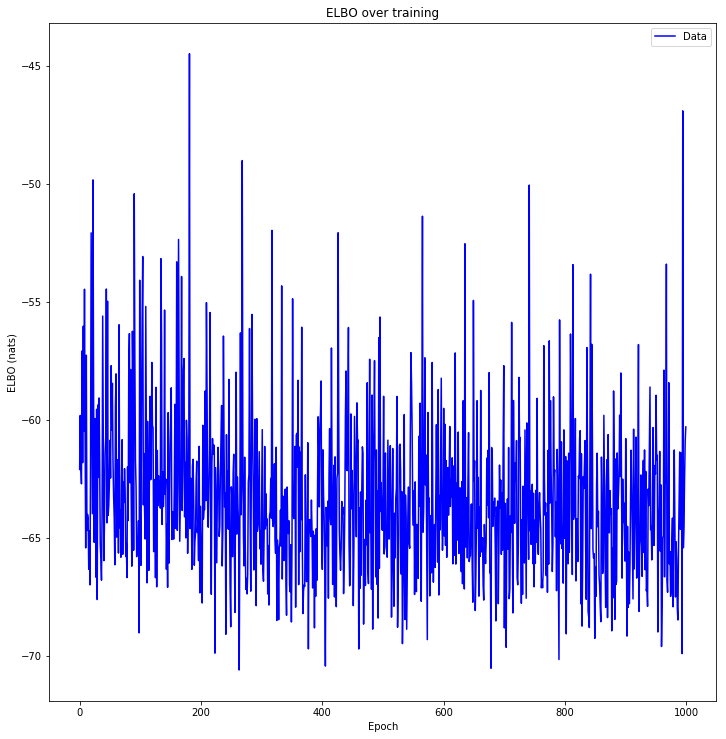

In [13]:
utils.plot_evidence_bounds(elbos)

In [14]:
for t in range(1, zs.shape[0]):
    key = generative.find(lambda k, v: ('Z_%d' % t) in k)[0]
    accuracy = ((inference[key].value - utils.optional_to(generative[key], inference[key].value))**2).mean()
    print('SMC MSE at time %d: %f' % (t, accuracy))

SMC MSE at time 1: 1.005206
SMC MSE at time 2: 2.075948
SMC MSE at time 3: 1.633483
SMC MSE at time 4: 0.902242
SMC MSE at time 5: 1.354460
SMC MSE at time 6: 1.324613
SMC MSE at time 7: 1.407605
SMC MSE at time 8: 1.204390
SMC MSE at time 9: 0.898651
SMC MSE at time 10: 2.233746
SMC MSE at time 11: 0.962328
SMC MSE at time 12: 0.799802
SMC MSE at time 13: 0.777347
SMC MSE at time 14: 1.625722
SMC MSE at time 15: 0.694814
SMC MSE at time 16: 0.615172
SMC MSE at time 17: 1.117407
SMC MSE at time 18: 0.691502
SMC MSE at time 19: 0.842972
SMC MSE at time 20: 1.775254
SMC MSE at time 21: 0.962902
SMC MSE at time 22: 0.720388
SMC MSE at time 23: 3.516336
SMC MSE at time 24: 1.093741
SMC MSE at time 25: 0.742554
SMC MSE at time 26: 0.572193
SMC MSE at time 27: 0.897426
SMC MSE at time 28: 0.563586
SMC MSE at time 29: 1.074846
SMC MSE at time 30: 0.761852
SMC MSE at time 31: 0.825104
SMC MSE at time 32: 0.898018
SMC MSE at time 33: 1.369064
SMC MSE at time 34: 1.166754
SMC MSE at time 35: 0.9

In [15]:
particle_mh = mcmc.LightweightMH(ssm_score)

In [16]:
lookup = utils.dict_lookup(data)
samples, inference = particle_mh(data=data, trace=inference)

In [17]:
inference

In [18]:
generative

In [19]:
for t in range(1, zs.shape[0]):
    key = generative.find(lambda k, v: ('Z_%d' % t) in k)[0]
    accuracy = ((inference[key].value - utils.optional_to(generative[key], inference[key].value))**2).mean()
    print('SMC MSE at time %d: %f' % (t, accuracy))

SMC MSE at time 1: 0.571816
SMC MSE at time 2: 1.129297
SMC MSE at time 3: 1.065421
SMC MSE at time 4: 0.381739
SMC MSE at time 5: 0.301981
SMC MSE at time 6: 0.524304
SMC MSE at time 7: 0.554722
SMC MSE at time 8: 0.355181
SMC MSE at time 9: 1.167894
SMC MSE at time 10: 1.160179
SMC MSE at time 11: 0.203385
SMC MSE at time 12: 0.351312
SMC MSE at time 13: 0.314565
SMC MSE at time 14: 0.727785
SMC MSE at time 15: 1.974460
SMC MSE at time 16: 0.574711
SMC MSE at time 17: 0.034612
SMC MSE at time 18: 0.013041
SMC MSE at time 19: 0.536659
SMC MSE at time 20: 0.989657
SMC MSE at time 21: 0.292424
SMC MSE at time 22: 0.783169
SMC MSE at time 23: 2.509577
SMC MSE at time 24: 0.163491
SMC MSE at time 25: 0.213851
SMC MSE at time 26: 0.372062
SMC MSE at time 27: 0.456387
SMC MSE at time 28: 0.593675
SMC MSE at time 29: 0.741330
SMC MSE at time 30: 1.094226
SMC MSE at time 31: 0.164101
SMC MSE at time 32: 0.576095
SMC MSE at time 33: 1.555451
SMC MSE at time 34: 0.815046
SMC MSE at time 35: 0.2